Concluded that there's no obvious disk to try to track down; none of the lines obviously guide toward anything useful.

Distance from https://ui.adsabs.harvard.edu/abs/2011PASJ...63..513K%2F/abstract (Kurayama, VLBI parallax)

Also from Xu?

Apparently name mm1 comes from Rathborne 2006
https://ui.adsabs.harvard.edu/abs/2006ApJ...641..389R

Csengeri 2017 2017A&A...600L..10C gives best coordinates

In [1]:
from astropy import units as u
distance = 1.56*u.kpc 
vcen = 57.6 * u.km/u.s # from Patricio


In [2]:
cd /orange/adamginsburg/salt/sanhueza/G34.43

/orange/adamginsburg/salt/sanhueza/G34.43


In [3]:
# CARTA loading script

field = 'G34.43+0.24'
dirfield = 'G34.43'
spwmap = {
0: 234.251912,
1: 232.6867,
2: 217.817644,
3: 219.614936,
}
basepath = f"/salt/sanhueza/{dirfield}"
print(f"""const frame = await app.openFile("{basepath}/{field}.config8.cont_avg.selfcal_0.5_hogbom.image.fits");\n""")
for spw in (0,1,2,3):
      print(f"""
const frame{spw} = await app.appendFile("{basepath}/{field}.config8.spw{spw}.robust0.5.image_small.fits");
frame{spw}.restFreqStore.setCustomUnit("GHz");
frame{spw}.restFreqStore.setCustomVal({spwmap[spw]});
""")

const frame = await app.openFile("/salt/sanhueza/G34.43/G34.43+0.24.config8.cont_avg.selfcal_0.5_hogbom.image.fits");


const frame0 = await app.appendFile("/salt/sanhueza/G34.43/G34.43+0.24.config8.spw0.robust0.5.image_small.fits");
frame0.restFreqStore.setCustomUnit("GHz");
frame0.restFreqStore.setCustomVal(234.251912);


const frame1 = await app.appendFile("/salt/sanhueza/G34.43/G34.43+0.24.config8.spw1.robust0.5.image_small.fits");
frame1.restFreqStore.setCustomUnit("GHz");
frame1.restFreqStore.setCustomVal(232.6867);


const frame2 = await app.appendFile("/salt/sanhueza/G34.43/G34.43+0.24.config8.spw2.robust0.5.image_small.fits");
frame2.restFreqStore.setCustomUnit("GHz");
frame2.restFreqStore.setCustomVal(217.817644);


const frame3 = await app.appendFile("/salt/sanhueza/G34.43/G34.43+0.24.config8.spw3.robust0.5.image_small.fits");
frame3.restFreqStore.setCustomUnit("GHz");
frame3.restFreqStore.setCustomVal(219.614936);



In [4]:
%%bash
ls $PWD/G34.43+0.24.config8.cont_avg.selfcal_0.5_hogbom.image.fits

/orange/adamginsburg/salt/sanhueza/G34.43/G34.43+0.24.config8.cont_avg.selfcal_0.5_hogbom.image.fits


In [5]:
ls

cutout.reg
G34.43+0.24.config8.cont_avg.selfcal_0.5_hogbom.image.fits
G34.43+0.24.config8.spw0.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw0.robust0.5.image_small.fits
G34.43+0.24.config8.spw1.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw1.robust0.5.image_small.fits
G34.43+0.24.config8.spw2.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw2.robust0.5.image_small.fits
G34.43+0.24.config8.spw3.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw3.robust0.5.image_small.fits
NaCl_v_le_3_stackcube.fits
spectra/


In [6]:
targetname = 'G34.43+0.24'

for fn in glob.glob("*.fits"):
    print('app

In [7]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b264dc6b8e0>

In [8]:
from astropy.table import Table
from astropy import table

In [9]:
import pprint

In [10]:
import scipy, scipy.ndimage

In [11]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [12]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('cutout.reg')
#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [13]:
reg[0].center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (34.41132396, 0.23491391)>

In [14]:
from astroquery.simbad import Simbad
Simbad.query_region(reg[0].center, radius=10*u.arcsec)

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
[CBW2017] G034.4112+00.2344-MM1,18 53 18.02,+01 25 25.5,6,6,--,--,0,D,s,2017A&A...600L..10C,1
[LZL2014] IRAS 18507+0121 P1,18 53 18.000,+01 25 25.50,7,7,--,--,0,D,R,2014ApJ...790...84L,1
NAME G34.4MM,18 53 18.0319,+01 25 25.500,8,8,--,--,0,B,R,2019ApJ...885..131R,1
[SNB2004] 124,18 53 18.04,+01 25 25.2,6,6,--,--,0,D,,2004ApJ...602..850S,1
[SPW2007] G34.4B,18 53 18.0,+01 25 25,5,5,--,--,0,E,,,1
AGAL G034.411+00.234,18 53 18.0,+01 25 24,5,5,--,--,0,D,m,2006ApJ...641..389R,1
EGO G034.41+0.24,18 53 17.9,+01 25 25,5,5,--,--,0,D,I,2008AJ....136.2391C,1
[SNB2004] 133,18 53 17.91,+01 25 28.3,6,6,--,--,0,D,,2004ApJ...602..850S,1


(1996.0, 2089.0, 2005.0, 2097.0)

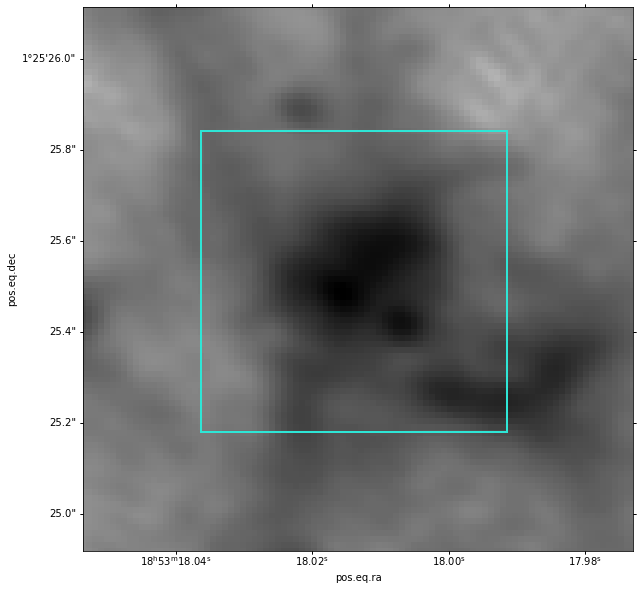

In [15]:
cont = SpectralCube.read('G34.43+0.24.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
#reg2[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
#regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [16]:
from spectral_cube.analysis_utilities import stack_cube

In [17]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [18]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [19]:
flist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_small.fits'))

In [20]:
flist

['G34.43+0.24.config8.spw3.robust0.5.image_small.fits',
 'G34.43+0.24.config8.spw2.robust0.5.image_small.fits',
 'G34.43+0.24.config8.spw0.robust0.5.image_small.fits',
 'G34.43+0.24.config8.spw1.robust0.5.image_small.fits']

In [21]:
#from dask.diagnostics import ProgressBar
#pbar = ProgressBar()
#pbar.register()

import dask
dask.config.set(scheduler='threads', num_workers=8)

In [22]:
for fn in flist:
    for rr,regn in ( (reg, 'co1'), ):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile) or SpectralCube.read(fn, use_dask=True).unit != u.K:
            cube = SpectralCube.read(fn, use_dask=False).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            #with cube.use_dask_scheduler('threads', num_workers=8):
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb).to(u.K)
            scube.write(outfile, overwrite=True)

In [23]:
regn = "co1"
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(3866, 50, 52) and unit=K and chunk size (3866, 50, 52):
  n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
  n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
  n_s:   3866  type_s: FREQ      unit_s: Hz     range: 219062738860.000 Hz:220949992551.736 Hz,
 DaskSpectralCube with shape=(3866, 50, 52) and unit=K and chunk size (3866, 50, 52):
  n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
  n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
  n_s:   3866  type_s: FREQ      unit_s: Hz     range: 216862738681.100 Hz:218749992372.836 Hz,
 DaskSpectralCube with shape=(1933, 50, 52) and unit=K and chunk size (1933, 50, 52):
  n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
  n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
  n_s:   1933  t

In [24]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()

In [25]:
cb

Beam: BMAJ=0.10545357896124365 arcsec BMIN=0.07615044361590363 arcsec BPA=61.24926403267721 deg

In [26]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 164.50758318 AU>

In [27]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 118.79469204 AU>

In [28]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [29]:
from astropy import log
log.setLevel('INFO')

In [30]:
#log.setLevel('DEBUG')
vcen = 57.6 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-25*u.km/u.s,
                   vmax=vcen+25*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [31]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(75, 50, 52) and unit=K:
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:       32.616 km / s:      82.311 km / s

In [32]:
jtok = stackc.beam.jtok(217*u.GHz)

In [33]:
232.6867*(1-vcen/constants.c).decompose()

<Quantity 232.64199323>

In [34]:
pl.rcParams['image.origin'] = 'lower'

DaskSpectralCube with shape=(1933, 50, 52) and unit=K and chunk size (1933, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   1933  type_s: FREQ      unit_s: Hz     range: 231062983982.800 Hz:232949749381.214 Hz
DaskSpectralCube with shape=(33, 50, 52) and unit=K and chunk size (33, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:     33  type_s: VRAD      unit_s: km / s  range:       37.299 km / s:      77.562 km / s


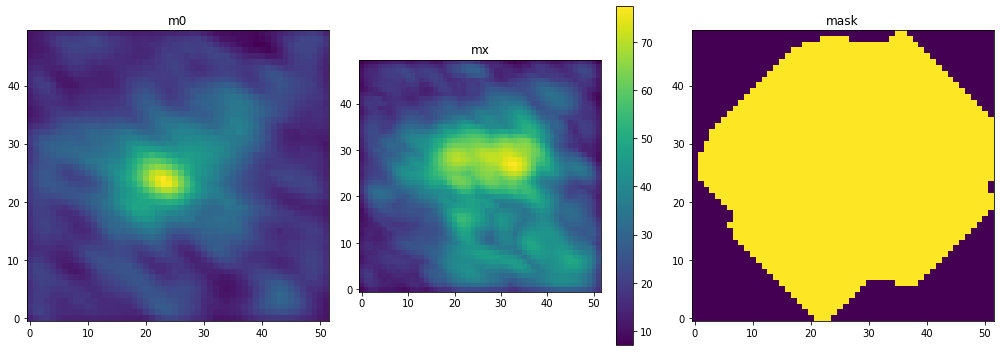

<Figure size 432x288 with 0 Axes>

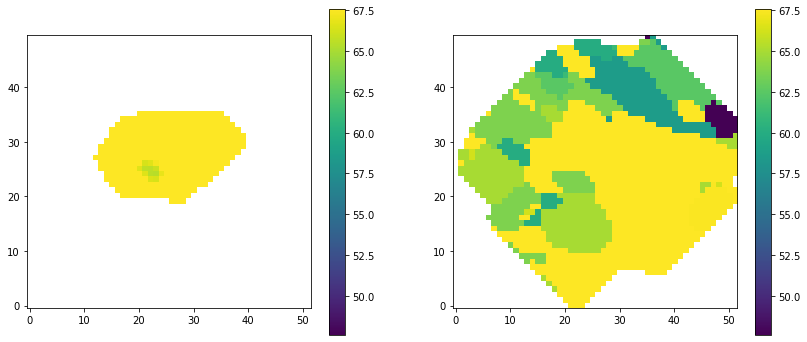

In [36]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                                                          velocity_convention='radio',
                                                          rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 50*u.K
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()



from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 40*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()





m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar()


vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

DaskSpectralCube with shape=(3866, 50, 52) and unit=K and chunk size (3866, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   3866  type_s: FREQ      unit_s: Hz     range: 216862738681.100 Hz:218749992372.836 Hz
DaskSpectralCube with shape=(61, 50, 52) and unit=K and chunk size (61, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:     61  type_s: VRAD      unit_s: km / s  range:       37.365 km / s:      77.689 km / s
INFO: Auto-setting vmin to  1.849e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.517e+02 [aplpy.core]
INFO: Auto-setting vmin to  3.474e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.178e+02 [aplpy.core]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

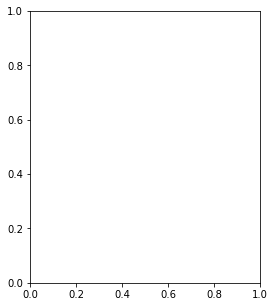

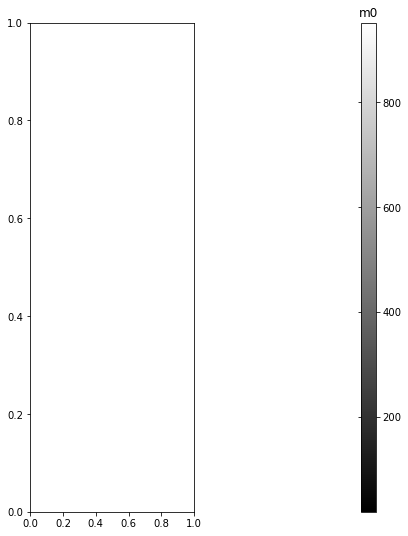

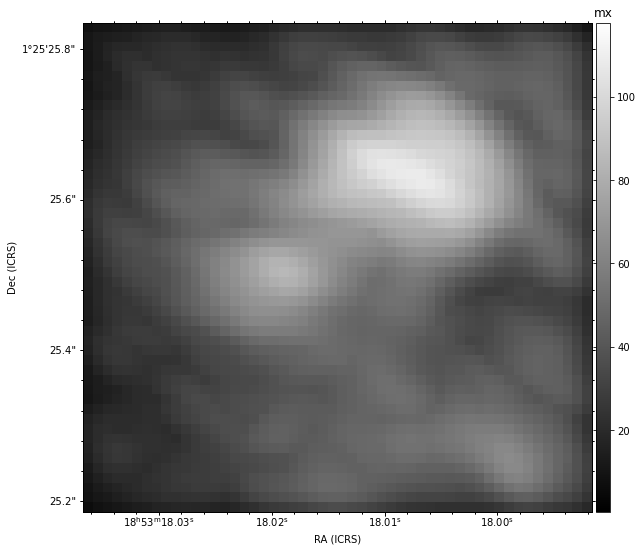

In [37]:
# try creating a vmap based on another line (SiS 12-11)
restval = 217.81764400*u.GHz # '': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.022*mx.unit*jtok.value
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*stackc.unit*jtok.value).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu

In [ ]:
stackc = stackc.subcube_from_regions(reg)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.0115*mx.unit*jtok.value
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=15)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0001*stackc.unit*jtok.value).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


vmap = m1.hdu

In [ ]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [ ]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [ ]:
mkdir -p spectra/figures

In [ ]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [ ]:
ls spectra/figures

In [ ]:
from IPython.display import Image,display

In [ ]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

In [ ]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy.io import fits


cbflist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_co1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    print(basename)
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg)
    # continuum subtract before stacking
    scube = scube - scube.percentile(25, axis=0)
    #mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj.value, header=scube.wcs.celestial.to_header()).writeto('vmap.fits', overwrite=True)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [ ]:
ls spectra

In [ ]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[4]}_stack'
    stackspectra.append(pysp)

In [ ]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures')

In [ ]:
ls spectra/figures/

In [ ]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))